In [1]:
%matplotlib inline
import numpy as np
import scipy.special as sc
from scipy import stats
import scipy.linalg as scalg
import matplotlib.pyplot as plt
import pdb
from deprojectVis import deproject_vis
from scipy.linalg import cho_factor, cho_solve

In [2]:
#Squared exponential kernel
def exp2kernel(i1, i2, ibins=None, a=None, l=None):
    ri = ibins[i1]
    rj = ibins[i2]
    tol = 1e-6
    nugget = np.zeros_like(ri)
    nugget[(ri-rj)<tol] = 1e-16 #AD HOC!        
    return a*a * np.exp(-((ri - rj)**2.)/(2.*l*l))+nugget

#Covariance matrix for intensities
def calccovar(binsin, ain, lin):
    '''
    Calculate the covariance matrix using a squared exponential kernel
    a: normalization amplitude
    l: correlation length
    '''
    nbins = binsin.shape[0]
    cov = np.fromfunction(exp2kernel,(nbins,nbins), ibins=binsin, a=ain, l=lin, dtype = np.int)
    return cov


In [3]:
##1 - Data setup
##We have Ndata data visibilities (D), with covariance matrix Sigma

#1a. Read in visibility data
visfilename = 'DATA/fullA_nf_discrete.vis.npz' ##Set _nf_discrete
datfile = np.load(visfilename)
Dorig = datfile['Vis']
uorig = datfile['u']
vorig = datfile['v']
rhoorig = np.sqrt(uorig**2. + vorig**2.)
Dwgtorig = datfile['Wgt']
#Sigmainv = np.diag(Dwgtorig) #a little unnecessary

#1b. Deproject (and optionally bin) the visibilities so that they're face-on
incl = 50. #deg
PA = 70. #deg
offx = -0.3 #arcsec
offy = -0.2 #arcsec
#visbins = np.arange(1., np.amax(rhoorig)/1000, 10) #Visibility bins
nvisbins = 100. ##Set
if (nvisbins>1):
   #visbins = np.linspace(np.amin(rhoorig)/1000., np.amax(rhoorig)/1000., nvisbins)
   #!!MAY NEED CHANGING!!
   visbins = stats.mstats.mquantiles(rhoorig/1000, np.arange(nvisbins)/nvisbins) #Changing the bins to have roughly even numbers of visibilities in each        
   rhodeproj, Ddeproj, sigdeproj = deproject_vis([uorig, vorig, Dorig, Dwgtorig], visbins, incl, PA, offx, offy, errtype='scat')
else:
   rhodeproj, Ddeproj, sigdeproj = deproject_vis([uorig, vorig, Dorig, Dwgtorig], incl=incl, PA=PA, offx=offx, offy=offy)

#1c. Set data variables (currently only using real parts)
arcsec = 180./np.pi*3600.
D = Ddeproj.real
rho = rhodeproj/arcsec #units of 1/arcsec
Sigmainv = np.diag(1./np.square(sigdeproj.real))
Ndata = D.size
print 'Number of vis is', Ndata, np.shape(rho), np.shape(Sigmainv)

Number of vis is 100 (100,) (100, 100)


In [4]:
##2 - Model Setup
##We have a model visibility (M) which uses Nbins annuli

#Select model annuli radii in arcsec
rmin = 0.01/140.
rmax = 1.1
Nbins = 40
radii = np.linspace(rmin, rmax, num=Nbins+1) #Currently does NOT use rin
rleft = radii[:-1]
rright = radii[1:]
rcenter = (rleft+rright)/2.

#M=Xw, where X is only a function of the bins and baselines
X = np.empty([Ndata,Nbins])
for j in range(Ndata):
    for i in range(Nbins):
        X[j][i] = 1./rho[j]*(rright[i]*sc.j1(rho[j]*2.*np.pi*rright[i]) - rleft[i]*sc.j1(rho[j]*2.*np.pi*rleft[i]))

In [5]:
##3 - Compute linear algebra

#Calculate uniform prior mean and covariance matrix
#The mean of the distribution with a uniform prior is wu, with covariance Cu
Cu = np.dot(np.dot(X.T, Sigmainv), X)
#Alternate method without inverse
wu = np.linalg.solve(Cu, np.dot(np.dot(X.T, Sigmainv), D)) #better than wu0

In [6]:
#Calculate the mean to use for GP kernel (for now it's the truth)
flux = 0.12
sig = 0.6
incl = 50.
PA = 70.
offx = -0.3
offy = -0.2
nominal_SB = (sig/rcenter)**0.7 * np.exp(-(rcenter/sig)**2.5)	# fullA distribution
int_SB = np.trapz(2.*np.pi*nominal_SB*rcenter, rcenter)		# a check on the total flux
nominal_SB *= flux / int_SB

muw = nominal_SB #Truth

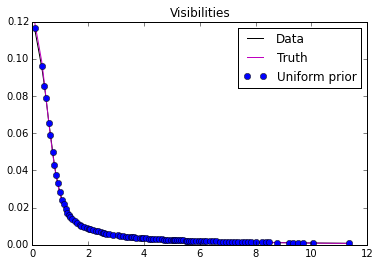

In [7]:
#Plot visibilities to compare data, truth, and uniform output
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.title('Visibilities')
plt.legend()

!!This tends to look better for smaller Ndata, suggesting there still may be an issue with wu calculation!!


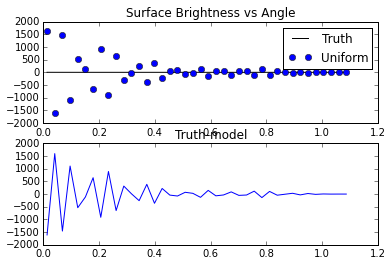

In [8]:
#Plot SB to compare data, truth, and uniform output
plt.subplot(211)
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.legend()
plt.title ('Surface Brightness vs Angle')
plt.subplot(212)
plt.plot(rcenter, nominal_SB - wu)
plt.title('Truth-model')
print "!!This tends to look better for smaller Ndata, suggesting there still may be an issue with wu calculation!!"

In [9]:
#Calculate the GP covariance matrix (Cw) from the kernel (k), with mean muw
#The mean of the distribution with this prior is wgp, with variance Cgp
gpa = 1. #Hyperparameter amplitude
gpl = .05 #Hyperparameter lengthscale
Cw = calccovar(rcenter, gpa, gpl)
Cwinv = np.linalg.inv(calccovar(rcenter, gpa, gpl))

<matplotlib.colorbar.Colorbar instance at 0x10f1accb0>

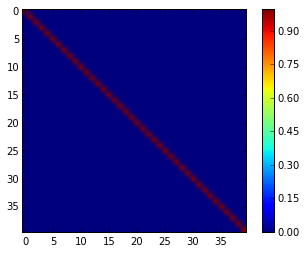

In [10]:
plt.imshow(np.dot(Cw, Cwinv))
plt.colorbar()
#If it doesn't look like the identity matrix, something is wrong! Check nugget term in kernel.

In [11]:
#Non-inverse method to getting wgp
Cgpinv = np.linalg.solve(Cu, np.eye(Nbins) + np.dot(Cu, Cwinv))
Cuinvwu = np.linalg.solve(Cu, wu)
wgp = np.linalg.solve(Cgpinv, Cuinvwu + np.dot(Cwinv, muw))

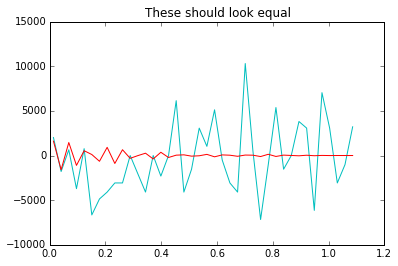

In [12]:
plt.plot(rcenter, np.dot(Cu, Cuinvwu), 'c') #Cu.inv(Cu).wu
plt.plot(rcenter, wu, 'r') #wu
plt.title('These should look equal')


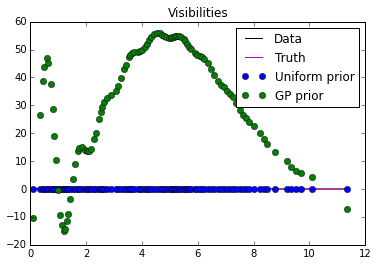

In [13]:
#Plot visibilities
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.plot(rho, np.dot(X, wgp), 'og', label='GP prior')
plt.title('Visibilities')
plt.legend()

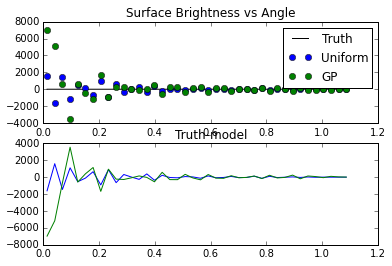

In [14]:
#Plot SB
plt.subplot(211)
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.plot(rcenter, wgp, 'og', label='GP')
plt.legend()
plt.title ('Surface Brightness vs Angle')
plt.subplot(212)
plt.plot(rcenter, nominal_SB - wu,'-b')
plt.plot(rcenter, nominal_SB - wgp, '-g')
plt.title('Truth-model')

#The Old Method That Uses Inverses

In [15]:
#The regular inverse way of doing all of this:
Cuinv0 = np.linalg.inv(Cu)
wu0 = np.dot(Cuinv0, np.dot(np.dot(X.T, Sigmainv), D)) 
Cgp0 = np.linalg.inv(Cuinv0+Cwinv)
wgp0 = np.dot(Cgp0,(np.dot(Cuinv0, wu0) + np.dot(Cwinv, muw)))

Cuinv0 does not work well


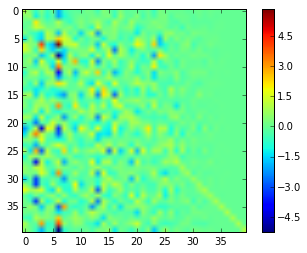

In [16]:
#Checking Cuinv0
plt.imshow(np.dot(Cu,Cuinv0))
plt.colorbar()
print 'Cuinv0 does not work well'

Truth [  1.10285933e+00   5.11774938e-01   3.56944597e-01   2.80448053e-01
   2.33122549e-01   2.00051406e-01   1.75062097e-01   1.55114427e-01
   1.38534036e-01   1.24325583e-01   1.11864686e-01   1.00744495e-01
   9.06927893e-02   8.15241385e-02   7.31107173e-02   6.53636321e-02
   5.82204790e-02   5.16367653e-02   4.55798370e-02   4.00245053e-02
   3.49498768e-02   3.03370710e-02   2.61676188e-02   2.24223941e-02
   1.90809734e-02   1.61213351e-02   1.35198285e-02   1.12513488e-02
   9.28965954e-03   7.60781372e-03   6.17862502e-03   4.97515136e-03
   3.97115687e-03   3.14152677e-03   2.46261649e-03   1.91252365e-03
   1.47127808e-03   1.12095084e-03   8.45687685e-04   6.31676313e-04]
With solve [  1.61161909e+03  -1.59456126e+03   1.45865434e+03  -1.10475197e+03
   5.37519733e+02   1.12379387e+02  -6.46094601e+02   9.15663891e+02
  -8.90241087e+02   6.50192926e+02  -3.15212962e+02  -1.09279572e+01
   2.59774021e+02  -3.84192229e+02   3.63126597e+02  -2.21076225e+02
   4.02956452e+0

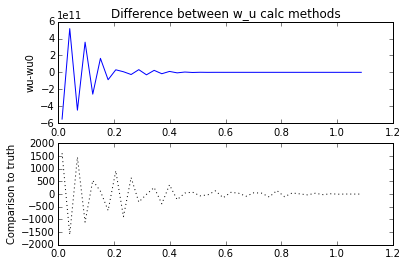

In [17]:
#Compare wu and wu0
print 'Truth', nominal_SB
print 'With solve', wu
print 'With inv', wu0
plt.subplot(211)
plt.plot(rcenter, wu-wu0)
plt.title('Difference between w_u calc methods')
plt.ylabel('wu-wu0')
plt.subplot(212)
plt.plot(rcenter, wu-nominal_SB, ':k', label='Truth')
plt.ylabel('Comparison to truth')


This should look like the identity matrix, but it depends strongly on the hyperparameters.


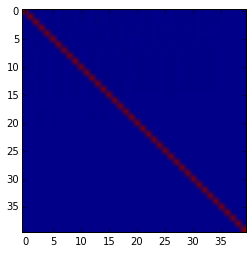

In [18]:
#Look at Cgp and Cgpinv
plt.imshow(np.dot(Cgp0, (Cuinv0+Cwinv)))
print 'This should look like the identity matrix, but it depends strongly on the hyperparameters.'

In [19]:
np.linalg.cond(Cu)/1e16

82.630719437078895

394881.799701


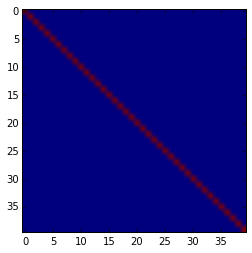

In [20]:
print np.amin(np.diag(Cu))
Cueps = Cu + np.eye(Nbins)*10.
np.linalg.cond(Cueps)/1e6
Cuepsinv = np.linalg.inv(Cueps)
plt.imshow(np.dot(Cueps, Cuepsinv))

In [21]:
wueps = np.dot(Cuepsinv, np.dot(np.dot(X.T, Sigmainv), D)) 
Cgpeps = np.linalg.inv(Cuepsinv+Cwinv)
wgpeps = np.dot(Cgpeps,(np.dot(Cuepsinv, wueps) + np.dot(Cwinv, muw)))

<matplotlib.colorbar.Colorbar instance at 0x110f8d830>

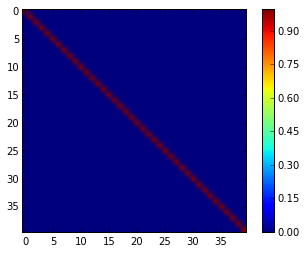

In [22]:
plt.imshow(np .dot(Cgpeps,Cuepsinv+Cwinv))
plt.colorbar()

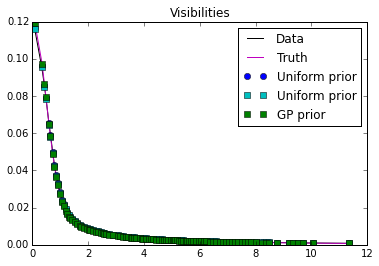

In [23]:
#Plot visibilities
plt.plot(rho, D, '-k', label='Data')
plt.plot(rho, np.dot(X, nominal_SB), '-m', label= 'Truth')
plt.plot(rho, np.dot(X, wu), 'ob', label='Uniform prior')
plt.plot(rho, np.dot(X, wueps), 'sc', label='Uniform prior')
#plt.plot(rho, np.dot(X, wgp), 'or', label='GP prior')
plt.plot(rho, np.dot(X, wgpeps), 'sg', label='GP prior')
plt.title('Visibilities')
plt.legend()

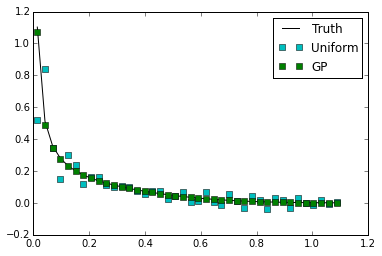

In [24]:
plt.plot(rcenter, nominal_SB, '-k', label='Truth')
#plt.plot(rcenter, wu, 'ob', label='Uniform')
plt.plot(rcenter, wueps, 'sc', label='Uniform')
#plt.plot(rcenter, wgp, 'or', label='GP')
plt.plot(rcenter, wgpeps, 'sg', label='GP')
plt.legend()

In [25]:
rcenter[2]-rcenter[1]

0.027498214285714292

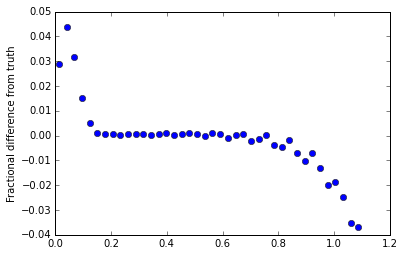

In [26]:
plt.plot(rcenter, (nominal_SB-wgpeps)/nominal_SB,'o')
plt.ylabel("Fractional difference from truth")

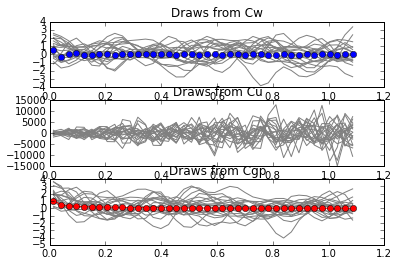

In [29]:
plt.subplot(311)
plt.title('Draws from Cw')
for draw in np.random.multivariate_normal(muw, Cw, size=20):
    plt.plot(rcenter, draw, color="0.5")

plt.plot(rcenter, nominal_SB-wueps, 'bo')

plt.subplot(312)       
plt.title('Draws from Cu')
for draw in np.random.multivariate_normal(wueps, Cueps, size=20):
    plt.plot(rcenter, draw, color="0.5")

#plt.plot(cb, result, color="b", label=r"$\hat{w}$")
#plt.plot(cb, wtilde, color="r", label=r"${w}~w/GP$")
#plt.plot(cb, nominal_SB, color="k", label="truth")


plt.subplot(313)
plt.title('Draws from Cgp')
this = np.random.multivariate_normal(wgpeps, Cgpeps, size=10000)

for draw in np.random.multivariate_normal(wgpeps, Cgpeps, size=20):
    plt.plot(rcenter, draw, color="0.5")
#plt.plot(cb, result, color="b", label=r"$\hat{w}$", marker = 'o', linestyle='-')
plt.plot(rcenter, wgpeps, color="r", label=r"${w}~w/GP$", marker = 'o', linestyle='-')
#plt.plot(cb, nominal_SB, color="k", label="truth")


# plt.legend(loc="upper right")

In [83]:
2

2